In [13]:
import pandas as pd
import numpy as np
import string
import re
import spacy
import en_core_web_sm
import matplotlib.pyplot as plt
from subprocess import check_output
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.sklearn

In [14]:
df = pd.read_csv('raw_trump_tweets.csv', encoding='UTF-8')
print(len(df), 'tweets')

54442 tweets


In [15]:
df.head()

,id,text,isRetweet,isDeleted,device,favorites,retweets,date
0,9.845500e+16,Republicans and Democrats have both created ou...,f,f,TweetDeck,49,255,2/8/2011 18:07
1,1.234650e+18,I was thrilled to be back in the Great city of...,f,f,Twitter for iPhone,73748,17404,3/3/2020 1:34
2,1.218010e+18,RT @CBS_Herridge: READ: Letter to surveillance...,t,f,Twitter for iPhone,0,7396,17/1/2020 3:22
3,1.304880e+18,The Unsolicited Mail In Ballot Scam is a major...,f,f,Twitter for iPhone,80527,23502,12/9/2020 20:10
4,1.218160e+18,RT @MZHemingway: Very friendly telling of even...,t,f,Twitter for iPhone,0,9081,17/1/2020 13:13


In [16]:
df = df[df['isRetweet'] == 'f']
#df = df[df['text'].str.contains('RT @') == False]
df['date']= pd.to_datetime(df['date'])
df = df[df['date'] >= np.datetime64('2017-01-20')]
df = df[df['date'] <= np.datetime64('2018-12-31')]

In [17]:
tweets = df.loc[:, ['text']].reset_index(drop=True)
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5262 entries, 0 to 5261
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5262 non-null   object
dtypes: object(1)
memory usage: 41.2+ KB


In [18]:
x = 1000

for i in range(x, x+10):
    print(tweets.text[i])
    print()

A great book by a great guy, highly recommended! https://t.co/3jbDDN8YmJ

Wonderful coordination between Federal, State and Local Governments in the Great State of Texas - TEAMWORK! Record setting rainfall.

THANK YOU to all of the great volunteers helping out with #HurricaneHarvey relief in Texas! https://t.co/Ds95oSgo8f

Closely monitoring #HurricaneHarvey from Camp David. We are leaving nothing to chance. City, State and Federal Govs. working great together!

.@ChuckGrassley - got your message loud and clear. We have fantastic people on the ground, got there long before #Harvey. So far, so good!

You are doing a great job - the world is watching! Be safe. https://t.co/PJLdxy3hD9

We will remain fully engaged w/ open lines of communication as #HurricaneHarvey makes landfall. America is w/ you! @GovAbbott @FEMA @DHSgov https://t.co/PryIqRxgLr

I am pleased to inform you that I have just granted a full Pardon to 85 year old American patriot Sheriff Joe Arpaio. He kept Arizona safe!

At

In [38]:
import pandas as pd
import numpy as np
import json
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re, string, unicodedata
import nltk
from nltk import word_tokenize, sent_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
import preprocessor as p

def twee(text):
    text1 = p.clean(text)
    return text1

tweets_clean = pd.DataFrame(tweets.text.apply(lambda x: twee(x)))

def remove_hashtag(text):
    text2 = re.sub(r'#(\w+)', '', text)
    return text2

tweets_clean = pd.DataFrame(tweets_clean.text.apply(lambda x: remove_hashtag(x)))
    
def preprocess_data(data):
 #Removes Numbers
    data = data.astype(str).str.replace(r'\d+', '')
    lower_text = data.str.lower()
    lemmatizer = nltk.stem.WordNetLemmatizer()
    w_tokenizer =  TweetTokenizer()
                
    def lemmatize_text(text):
        return [(lemmatizer.lemmatize(w)) for w in w_tokenizer.tokenize((text))]

    def remove_punctuation(words):
        new_words = []
        for word in words:
            new_word = re.sub(r'[^\w\s]', '', (word))
            if new_word != '':
                new_words.append(new_word)
        return new_words
    
    words = lower_text.apply(lemmatize_text)
    words = words.apply(remove_punctuation)
    return pd.DataFrame(words)

tweets_clean['text'] = preprocess_data(tweets_clean['text'])

stop_words = set(set(stopwords.words('english')).union({'amp', 'let'}))
tweets_clean['text'] = tweets_clean['text'].apply(lambda x: [item for item in x if item not in stop_words])
tweets_clean['text'] = tweets_clean['text'].apply(lambda x: " ".join(x))

In [39]:
x = 800

for i in range(x, x+10):
    print(tweets_clean.text[i])
    print()



rating nfl football way except game start people tune see whether country disrespected

big election tomorrow great state alabama vote senator luther strange tough crime border never

many clip john mccain talking repealing replacing ocare oh ha changedcomplete turn year talk

owed wall street bank sadly must dealt food water medical top priority well

old electrical grid wa terrible shape wa devastated much island wa destroyed billion dollar

texas florida great puerto rico wa already suffering broken infrastructure massive debt deep trouble

tremendous backlash nfl player disrespect country

general john kelly totally agrees w stance nfl player fact disrespecting flag great country

reported co john kelly wa opposed stance nfl player disrespecting flag anthem country total lie



In [7]:
def clean_text(text):
#Make text lowercase   
    text = text.lower()
#remove url
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'#(\w+)', '', text)
#remove punctuation   
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text) 
#remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)
    
    return text

tweets_clean = pd.DataFrame(tweets.text.apply(lambda x: clean_text(x)))

In [9]:
nlp = en_core_web_sm.load()
def lemmatizer(text):        
    sent = []
    doc = nlp(text)
    for word in doc:
        sent.append(word.lemma_)
    return " ".join(sent)

tweets_clean = pd.DataFrame(tweets_clean.text.apply(lambda x: lemmatizer(x)))
tweets_clean['text'] = tweets_clean['text'].str.replace('-PRON-', '')

In [12]:
x = 800

for i in range(x, x+10):
    print(tweets_clean.text[i])
    print()

hurricaneflorence  

rating for nfl football be way down except before game start when people tune in to see whether or not  country will be disrespect

big election tomorrow in the great state of alabama vote for senator luther strange tough on crime amp border   will never let  down

a few of the many clip of john mccain talk about repeal amp replace ocare  oh my have  changedcomplete turn from year of talk

owe to wall street and the bank which sadly must be deal with food water and medical be top priority   and do well fema

 old electrical grid which be in terrible shape be devastate much of the island be destroy with billion of dollar

texas amp florida be do great but puerto rico which be already suffer from broken infrastructure amp massive debt be in deep trouble

tremendous backlash against the nfl and  player for disrespect of  countrystandforouranthem 🇺 🇸

general john kelly totally agree w  stance on nfl player and the fact that  should not be disrespect  flag or great cou

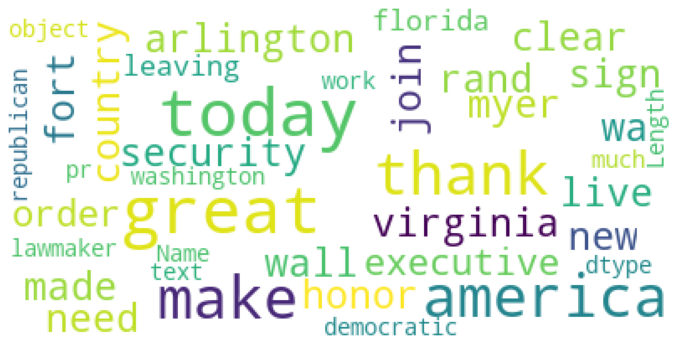

In [41]:
plt.rcParams['figure.figsize'] = (12.0,12.0)  
plt.rcParams['font.size'] = 12            
plt.rcParams['savefig.dpi'] = 100             
plt.rcParams['figure.subplot.bottom'] = .1 
wordcloud = WordCloud(background_color='white',
                      stopwords=stop_words,
                      max_words=500,
                      max_font_size=40, 
                      random_state=100
                      ).generate(str(tweets_clean.text))
print(wordcloud)
#fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [43]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words=stop_words).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    return words_freq[:n]

common_words = get_top_n_words(tweets_clean.text, 10)
unigram = pd.DataFrame(common_words, columns = ['unigram' , 'count'])

In [44]:
print(unigram)

     unigram  count
0      great   1308
1         wa    783
2         ha    636
3     people    631
4    country    554
5       news    452
6        job    438
7   democrat    437
8  president    417
9        big    415


In [45]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3,3),stop_words=stop_words).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    return words_freq[:n]

common_words = get_top_n_trigram(tweets_clean.text, 10)
trigram = pd.DataFrame(common_words, columns = ['trigram' , 'count'])

In [46]:
print(trigram)

                trigram  count
0      fake news medium    100
1    make america great     91
2        wa great honor     73
3   strong crime border     34
4     love military vet     33
5  making america great     30
6         new york time     28
7     rigged witch hunt     28
8           kim jong un     27
9        tax cut reform     27


In [47]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=3,# minimum required occurences of a word 
                             stop_words='english',# remove stop words
                             lowercase=True,# convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',# num chars > 3
                             max_features=5000,# max number of unique words
                            )

data_matrix = vectorizer.fit_transform(tweets_clean.text)
data_matrix

<5262x3113 sparse matrix of type '<class 'numpy.int64'>'
	with 61156 stored elements in Compressed Sparse Row format>

In [48]:
lda_model = LatentDirichletAllocation(n_components=10, # Number of topics
                                      learning_method='online',
                                      random_state=20,       
                                      n_jobs = -1  # Use all available CPUs
                                     )

lda_output = lda_model.fit_transform(data_matrix)

In [49]:
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda_model, data_matrix, vectorizer, mds='tsne')

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
0      32.420952   8.115230       1        1  15.308222
5       0.648955  71.707100       2        1  14.407539
9      71.019684   9.971006       3        1  12.708924
2       3.785981  33.185135       4        1  10.423071
7     -42.666500  -9.222070       5        1  10.120360
3      -3.621689 -43.526516       6        1   8.726383
4      -3.632402  -4.171708       7        1   7.873877
8     -36.584400  35.804413       8        1   7.766195
1      44.391380  50.615383       9        1   7.175706
6      40.235809 -31.591665      10        1   5.489722, topic_info=            Term         Freq        Total Category  logprob  loglift
1190       great  1262.000000  1262.000000  Default  30.0000  30.0000
307       border   418.000000   418.000000  Default  29.0000  29.0000
1886        news   430.000000   430.000000  Default  28.0000  28.0000
110      america   339.000000   339.000000  Default  27.0000  27.0000
2756         tax   278.000000   278.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
3101        year    64.832634   399.741495  Topic10  -3.9996   1.0833
542   confidence    25.789809    35.980310  Topic10  -4.9214   2.5693
111     american    52.837640   311.996795  Topic10  -4.2042   1.1265
176          ask    23.592531    31.946328  Topic10  -5.0105   2.5992
1192    greatest    23.257309    47.169628  Topic10  -5.0248   2.1952

[501 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
3        10  0.945295      abc
4         9  0.947152      abe
37        3  0.122432   action
37        6  0.881509   action
50       10  0.954573  address
...     ...       ...      ...
3101      7  0.007505     year
3101      8  0.120078     year
3101     10  0.162605     year
3105      3  0.988357     york
3106     10  0.976801    young

[648 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 6, 10, 3, 8, 4, 5, 9, 2, 7])

In [50]:
for i,topic in enumerate(lda_model.components_):
    print(f'Top 10 words for topic #{i}:')
    print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 words for topic #0:
['good', 'new', 'year', 'witch', 'people', 'hunt', 'medium', 'job', 'fake', 'news']


Top 10 words for topic #1:
['new', 'welcome', 'general', 'congratulation', 'united', 'endorsement', 'state', 'honor', 'today', 'great']


Top 10 words for topic #2:
['president', 'including', 'people', 'money', 'look', 'world', 'china', 'like', 'deal', 'trade']


Top 10 words for topic #3:
['forward', 'good', 'day', 'meeting', 'white', 'korea', 'north', 'big', 'win', 'house']


Top 10 words for topic #4:
['country', 'national', 'people', 'happy', 'making', 'night', 'thank', 'make', 'america', 'great']


Top 10 words for topic #5:
['people', 'wall', 'security', 'need', 'crime', 'democrat', 'country', 'vote', 'great', 'republican']


Top 10 words for topic #6:
['november', 'american', 'highest', 'economic', 'true', 'melania', 'level', 'year', 'tonight', 'history']


Top 10 words for topic #7:
['people', 'mexico', 'woman', 'nation', 'thank', 'family', 'billion', 'country', 'law

In [52]:
topic_values = lda_model.transform(data_matrix)
tweets_clean['Topic'] = topic_values.argmax(axis=1)

In [54]:
tweets_clean.head()

,text,Topic
0,make america great,4
1,make america great,4
2,thank rand,5
3,thank,4
4,join live fort myer arlington virginia,6
